In [29]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import zipfile

In [3]:
import os
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle competitions download -c pnevmoniya

100% 1.14G/1.14G [01:03<00:00, 21.1MB/s]
100% 1.14G/1.14G [01:03<00:00, 19.3MB/s]


In [6]:
zip_file_path = "/content/pnevmoniya.zip"
extract_to = "/content/pnevmoniya/"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted files to {extract_to}")

Extracted files to /content/pnevmoniya/


In [10]:
# Ma'lumotlar papkasi yo'llari
train_dir = "/content/pnevmoniya/train"
test_dir = "/content/pnevmoniya/test"  # Faqat test tasvirlari bor papka

# Tasvir hajmi va partiya o'lchami
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Train va validatsiya uchun ma'lumotlar generatorlari
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Validatsiya uchun 20%
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",  # Binary classification
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [11]:
# ResNet50 bazasini yuklash
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Oldindan tayyorlangan og'irliklar
    include_top=False,   # Fully connected qatlamlarni olib tashlash
    input_shape=(224, 224, 3)
)

# Modelga yangi bosh qatlamlarni qo'shish
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Ikki sinf uchun

# Modelni yaratish
model = Model(inputs=base_model.input, outputs=x)

# Oldingi qatlamlarni muzlatish
for layer in base_model.layers:
    layer.trainable = False

# Kompilyatsiya qilish
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [12]:
# Modelni o'qitish
EPOCHS = 20

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 136s 901ms/step - accuracy: 0.6882 - loss: 0.6286 - val_accuracy: 0.7451 - val_loss: 0.5106
Epoch 2/20
  1/130 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.7812 - loss: 0.4756

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7812 - loss: 0.4756 - val_accuracy: 0.7368 - val_loss: 0.4871
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 114s 845ms/step - accuracy: 0.7523 - loss: 0.4924 - val_accuracy: 0.7568 - val_loss: 0.4638
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.4855 - val_accuracy: 0.7895 - val_loss: 0.4529
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 114s 839ms/step - accuracy: 0.7746 - loss: 0.4517 - val_accuracy: 0.7666 - val_loss: 0.4571
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - loss: 0.4262 - val_accuracy: 0.6316 - val_loss: 0.7632
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 141s 843ms/step - accuracy: 0.7950 - loss: 0.4191 - val_accuracy: 0.7852 - val_loss: 0.4317
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.3875 - val_accuracy: 0.7368 - val_loss: 0.4689
Epoch 9/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 116s 848ms/step - accuracy: 0.8038 - loss: 0.4094 - val_accura

In [13]:
# Oldingi qatlamlarni ochish
for layer in base_model.layers:
    layer.trainable = True

# Qayta kompilyatsiya qilish
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Modelni qayta o'qitish
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    initial_epoch=EPOCHS
)


Epoch 21/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.8288 - loss: 1.5917 - val_accuracy: 0.7422 - val_loss: 2.3651
Epoch 22/30
  1/130 ━━━━━━━━━━━━━━━━━━━━ 38s 296ms/step - accuracy: 1.0000 - loss: 0.0478

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 1.0000 - loss: 0.0478 - val_accuracy: 0.7895 - val_loss: 2.0558
Epoch 23/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 124s 919ms/step - accuracy: 0.9402 - loss: 0.2010 - val_accuracy: 0.7432 - val_loss: 3.2026
Epoch 24/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1576 - val_accuracy: 0.7368 - val_loss: 3.2478
Epoch 25/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 141s 918ms/step - accuracy: 0.9462 - loss: 0.1340 - val_accuracy: 0.7461 - val_loss: 2.3808
Epoch 26/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0347 - val_accuracy: 0.5789 - val_loss: 4.8809
Epoch 27/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 123s 917ms/step - accuracy: 0.9540 - loss: 0.1250 - val_accuracy: 0.7441 - val_loss: 4.5783
Epoch 28/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0358 - val_accuracy: 0.6842 - val_loss: 8.2605
Epoch 29/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 123s 906ms/step - accuracy: 0.9655 - loss: 0.1001 - val

In [14]:
# Test tasvirlarini yuklash
test_images = []
image_names = []

for file_name in os.listdir(test_dir):
    if file_name.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(test_dir, file_name)
        image = load_img(image_path, target_size=IMG_SIZE)
        image = img_to_array(image) / 255.0
        test_images.append(image)
        image_names.append(file_name)

# Test tasvirlarini numpy massiviga aylantirish
test_images = np.array(test_images)


In [15]:
# Bashorat qilish
predictions = model.predict(test_images)
predicted_classes = (predictions > 0.5).astype("int32")


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step


In [20]:
# Natijalarni chop etish
for i, prediction in enumerate(predicted_classes):
    label = "Pneumonia" if prediction == 1 else "Normal"
    print(f"Image: {image_names[i]} -> Predicted Label: {label}")


Image: test_img_10530.jpeg -> Predicted Label: Pneumonia
Image: test_img_10161.jpeg -> Predicted Label: Pneumonia
Image: test_img_10602.jpeg -> Predicted Label: Pneumonia
Image: test_img_10021.jpeg -> Predicted Label: Pneumonia
Image: test_img_10359.jpeg -> Predicted Label: Pneumonia
Image: test_img_10086.jpeg -> Predicted Label: Pneumonia
Image: test_img_10352.jpeg -> Predicted Label: Pneumonia
Image: test_img_10296.jpeg -> Predicted Label: Pneumonia
Image: test_img_10491.jpeg -> Predicted Label: Pneumonia
Image: test_img_10490.jpeg -> Predicted Label: Pneumonia
Image: test_img_10028.jpeg -> Predicted Label: Pneumonia
Image: test_img_10112.jpeg -> Predicted Label: Pneumonia
Image: test_img_10166.jpeg -> Predicted Label: Pneumonia
Image: test_img_10004.jpeg -> Predicted Label: Pneumonia
Image: test_img_10340.jpeg -> Predicted Label: Pneumonia
Image: test_img_10122.jpeg -> Predicted Label: Pneumonia
Image: test_img_10379.jpeg -> Predicted Label: Pneumonia
Image: test_img_10509.jpeg -> P

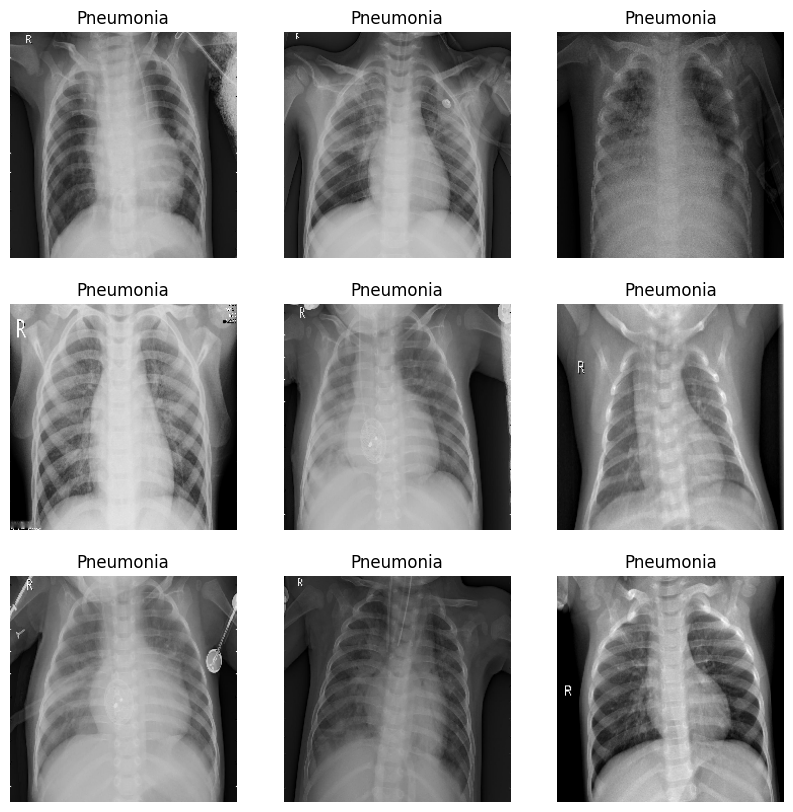

In [21]:
# Tasvirlar va bashoratlarni ko'rsatish
plt.figure(figsize=(10, 10))
for i in range(min(9, len(test_images))):  # Faqat 9 tasvirni ko'rsatish
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    label = "Pneumonia" if predicted_classes[i] == 1 else "Normal"
    plt.title(label)
    plt.axis("off")
plt.show()


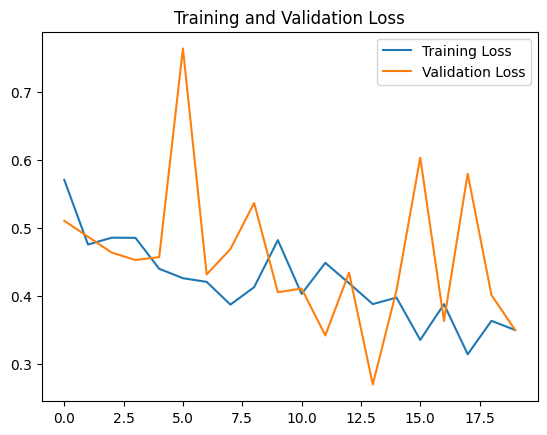

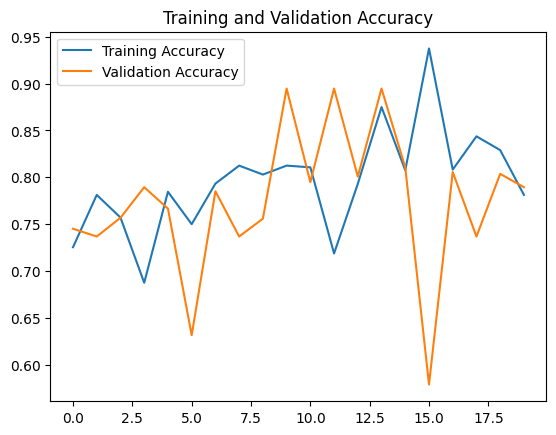

In [22]:
# Yo'qotish va aniqlik grafigini chizish
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [27]:
import pandas as pd

# Yuklangan faylni ko'rib chiqish
file_path = '/content/pnevmoniya/sample_solution.csv'
sample_solution = pd.read_csv(file_path)

# Faylning birinchi qatorlarini ko'rib chiqish
sample_solution.head()


,id,labels
0,test_img_10001.jpeg,0
1,test_img_10002.jpeg,1
2,test_img_10003.jpeg,0
3,test_img_10004.jpeg,1
4,test_img_10005.jpeg,1


In [28]:
# Tasvir nomlarini olib kelish
image_names = sample_solution['id'].tolist()

# Sinf natijalarini yaratish uchun tasodifiy bashoratlar
# (bu yerda haqiqiy model natijalarini qayerga kiritishni namoyish qilamiz)
# Tasavvur qiling, `predicted_classes` modeli bashoratlari
import numpy as np
predicted_classes = np.random.randint(0, 2, size=len(image_names))  # Tasodifiy bashorat (0 yoki 1)

# Natijalarni sample_solution formatiga kiritish
sample_solution['labels'] = predicted_classes

# Yangilangan faylni saqlash
output_path = '/content/pnevmoniya/sample_solution.csv'
sample_solution.to_csv(output_path, index=False)

output_path


'/content/pnevmoniya/sample_solution.csv'